# Import Required Library

In [1]:
import os, shutil
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import pickle

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tqdm import tqdm

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2, InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TFSMLayer
from tensorflow.keras.regularizers import l2

import kagglehub

from albumentations import (
    Compose, Resize, HorizontalFlip, VerticalFlip,
    Affine, RandomBrightnessContrast, HueSaturationValue,
    CLAHE, RandomGamma, Blur, GaussNoise, OneOf
)
from albumentations.core.composition import OneOf
from datetime import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import EfficientNetB4

2025-06-01 18:17:56.767099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748801877.010116      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748801877.072539      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Load Dataset

In [3]:
# Memuat dataset dari kaggle
path = kagglehub.dataset_download("dipoyonoarga/dataset-singkong")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dataset-singkong


In [4]:
# Memindahkan dataset ke writable folder
src = '/kaggle/input/dataset-singkong/Dataset-Singkong'
dst = '/kaggle/working/Dataset-Singkong'

if not os.path.exists(dst):
    shutil.copytree(src, dst)

In [5]:
# Mendefinisikan path ke dataset dan daftar kelas
dataset_path = '/kaggle/working/Dataset-Singkong'
classes = os.listdir(dataset_path)

# Mengecek isi dataset
print(classes)

['Cassava___healthy', 'Cassava___green_mottle', 'Cassava___brown_streak_disease', 'Cassava___bacterial_blight', 'Cassava___mosaic_disease']


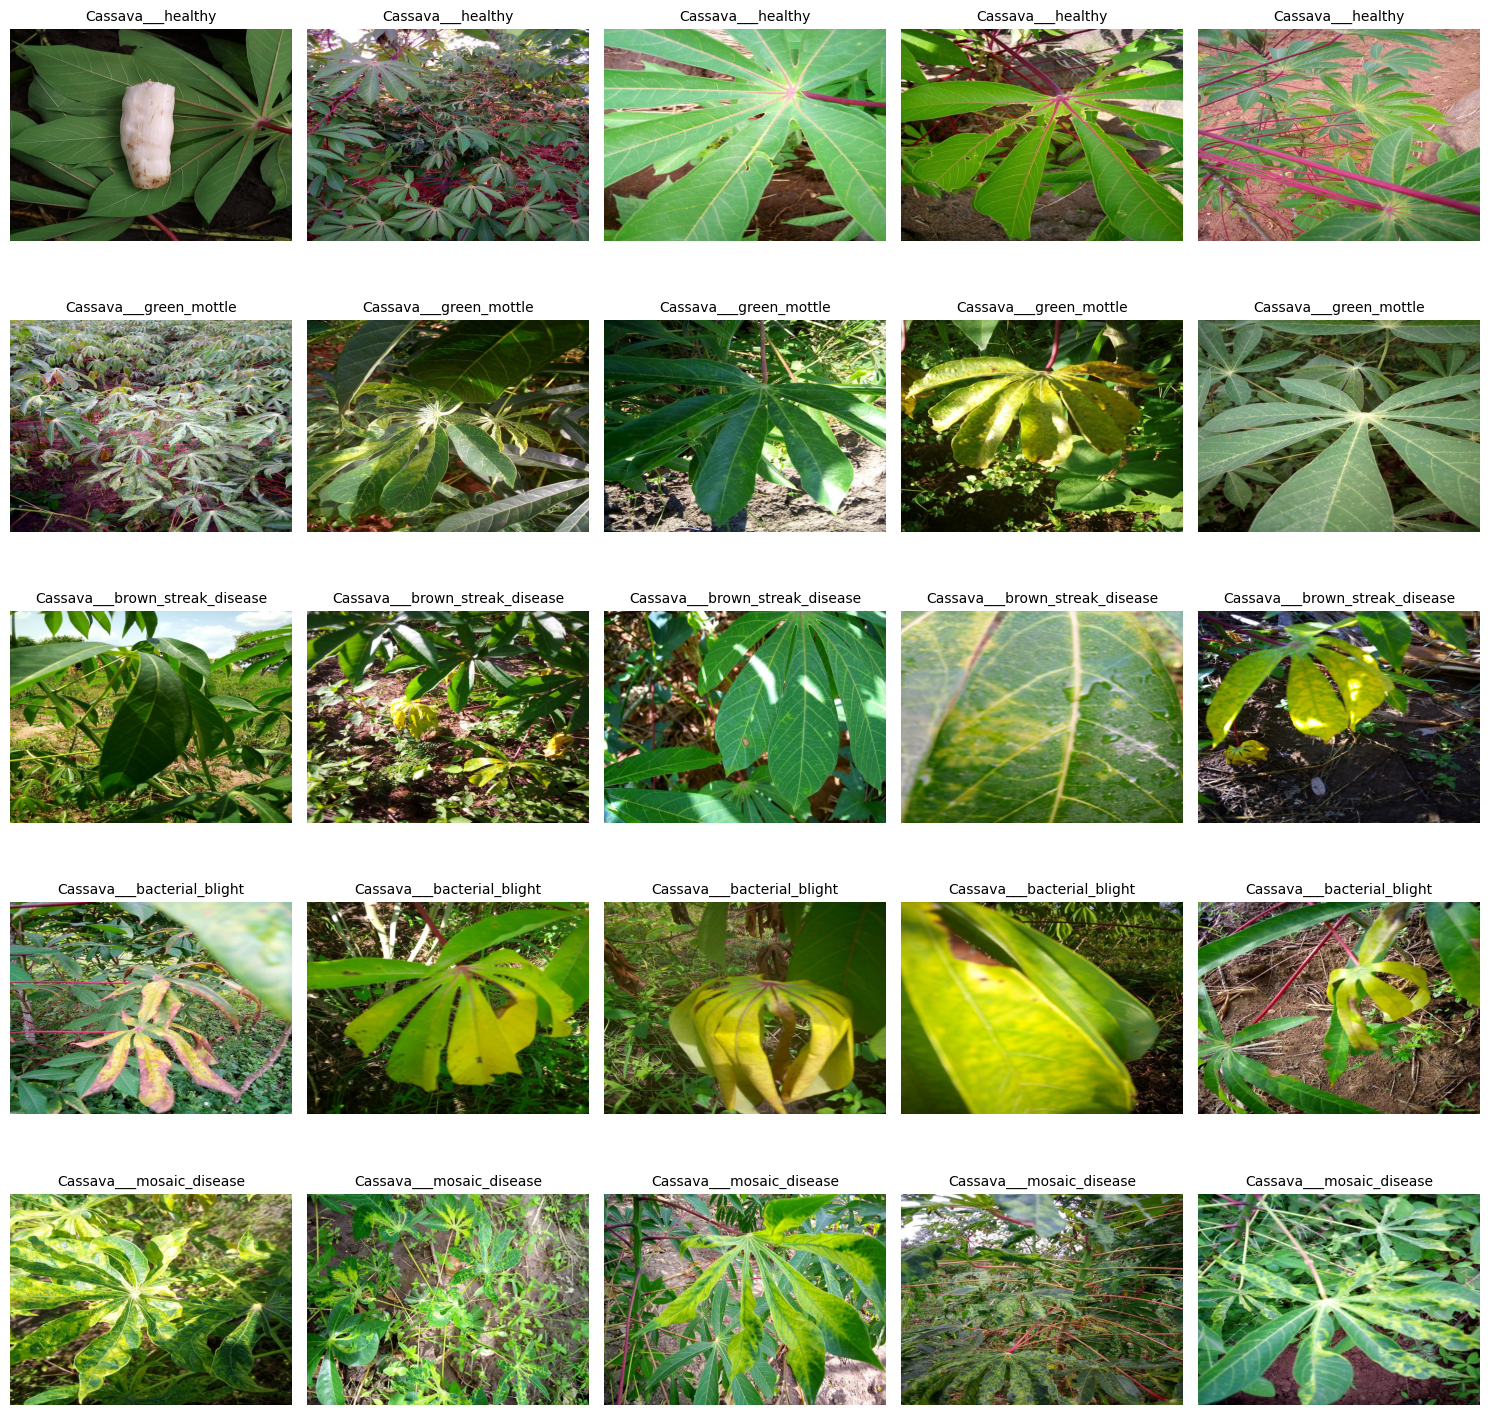

In [6]:
# Setup plot dengan ukuran yang dinamis berdasarkan jumlah kelas
plt.figure(figsize=(15, 3 * len(classes)))

# Loop melalui setiap kelas
for class_index, disease_class in enumerate(classes):
    class_folder_path = os.path.join(dataset_path, disease_class)
    image_files = os.listdir(class_folder_path)[:5]  # Ambil 5 gambar pertama

    # Loop melalui setiap gambar dalam kelas
    for image_index, image_file in enumerate(image_files):
      full_image_path = os.path.join(class_folder_path, image_file)

      # Menyipkan posisi subplot
      subplot_position = class_index * 5 + image_index + 1
      plt.subplot(len(classes), 5, subplot_position)

      # Menampilkan gambar
      plt.imshow(Image.open(full_image_path))
      plt.title(disease_class, fontsize=10)
      plt.axis('off')

plt.tight_layout()
plt.show()

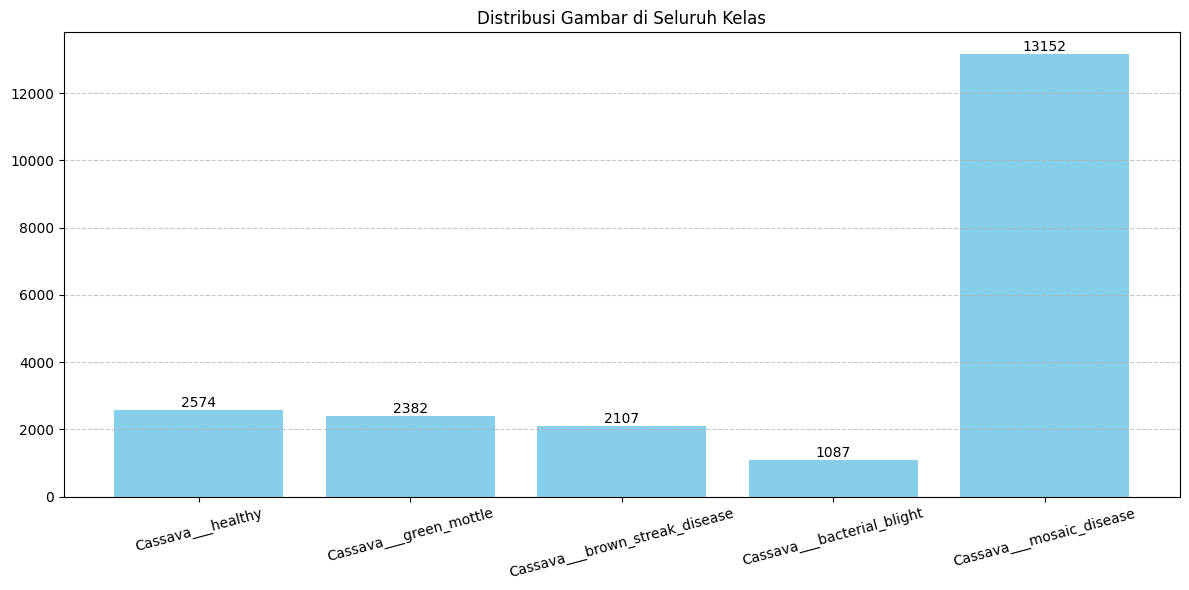

In [7]:
# Hitung jumlah gambar per kelas
imageCount = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Seluruh Kelas")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [8]:
# Undersampling, mengurangi jumlah dataset untuk semua kelas
base_folder_path = dataset_path
target_count_per_class = 2574 

for class_name in classes:
    folder_path = os.path.join(base_folder_path, class_name)
    if os.path.isdir(folder_path): 
        all_files = os.listdir(folder_path)
        random.shuffle(all_files)

        if len(all_files) > target_count_per_class:
            files_to_keep = set(all_files[:target_count_per_class])
            files_to_remove = [file for file in all_files if file not in files_to_keep]

            print(f"Mengurangi jumlah file di '{class_name}': Menghapus {len(files_to_remove)} file.")
            for file in files_to_remove:
                os.remove(os.path.join(folder_path, file))
        else:
            print(f"Jumlah file di '{class_name}' ({len(all_files)}) sudah kurang dari atau sama dengan target ({target_count_per_class}). Tidak ada file yang dihapus.")

# Verifikasi setelah pengurangan
print("\nJumlah file per kelas setelah pengurangan:")
imageCount_after = {class_name: len(os.listdir(os.path.join(base_folder_path, class_name))) for class_name in classes if os.path.isdir(os.path.join(base_folder_path, class_name))}
for class_name, count in imageCount_after.items():
    print(f"{class_name}: {count}")

Jumlah file di 'Cassava___healthy' (2574) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___green_mottle' (2382) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___brown_streak_disease' (2107) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___bacterial_blight' (1087) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.
Mengurangi jumlah file di 'Cassava___mosaic_disease': Menghapus 10578 file.

Jumlah file per kelas setelah pengurangan:
Cassava___healthy: 2574
Cassava___green_mottle: 2382
Cassava___brown_streak_disease: 2107
Cassava___bacterial_blight: 1087
Cassava___mosaic_disease: 2574


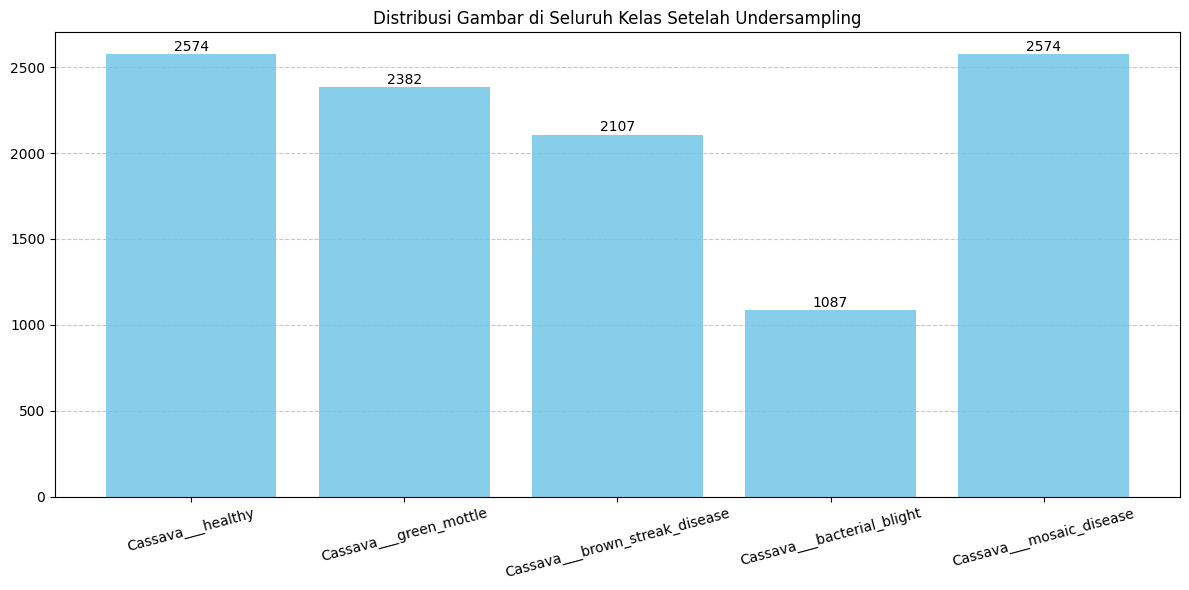

In [9]:
# Hitung jumlah gambar per kelas
imageCount = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Seluruh Kelas Setelah Undersampling")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Split dataset

In [10]:
# Split dataset
source_dir = '/kaggle/working/Dataset-Singkong'
output_base_dir = '/kaggle/working/Dataset-Ready'
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')
test_dir = os.path.join(output_base_dir, 'test')

# Rasio pembagian
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Membuat direktori tujuan
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Proses pemisahan tiap kelas
for class_name in tqdm(os.listdir(source_dir), desc='Memproses kelas'):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Ambil semua nama file gambar
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(train_ratio * total)
    val_count = int(val_ratio * total)
    test_count = total - train_count - val_count

    split_counts = {
        'train': images[:train_count],
        'val': images[train_count:train_count + val_count],
        'test': images[train_count + val_count:]
    }

    for split, split_images in split_counts.items():
        split_class_dir = os.path.join(output_base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in split_images:
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copy2(src_path, dst_path)

Memproses kelas: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


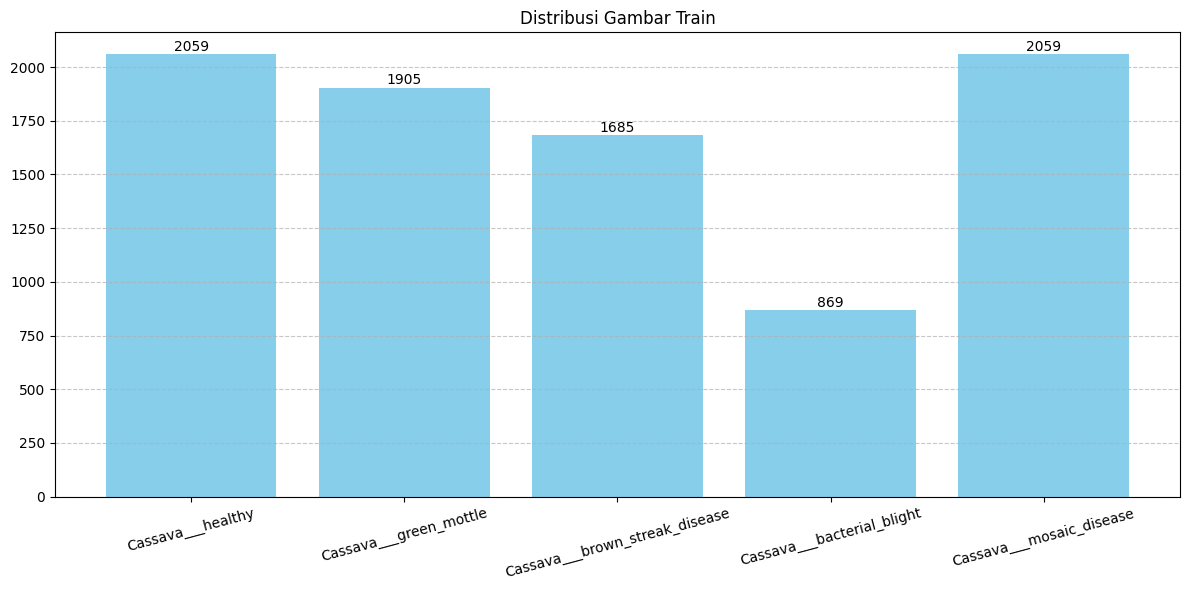

In [11]:
# Hitung jumlah gambar train
train_path = '/kaggle/working/Dataset-Ready/train'
imageCount = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar Train")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Image Augmentation

In [12]:
# Augmentasi gambar direktori train
train_dir = '/kaggle/working/Dataset-Ready/train' 
target_count = 2574
img_size = (150, 150)

transform = Compose([
    Resize(*img_size),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Affine(translate_percent=0.1, scale=(0.8, 1.2), rotate=(-30, 30), p=0.5),
    OneOf([
        RandomBrightnessContrast(p=0.5),
        HueSaturationValue(p=0.5),
        CLAHE(p=0.5)
    ], p=0.7),
    OneOf([
        Blur(blur_limit=3, p=0.3),
        GaussNoise(p=0.3)
    ], p=0.5),
    RandomGamma(p=0.3)
])

# Loop setiap kelas
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)
    needed = target_count - current_count

    print(f"\nAugmenting '{class_name}': current = {current_count}, need = {needed}")
    if needed <= 0:
        continue

    i = 0
    while i < needed:
        img_name = np.random.choice(image_files)
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue

        # Convert BGR to RGB (albumentations expects RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Menerapkan augmentasi
        augmented = transform(image=img)
        aug_img = augmented['image']

        # Konversi ke BGR 
        aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

        # Simpan dengan nama unik
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S%f")
        save_name = f"aug_{i}_{timestamp}.jpg"
        save_path = os.path.join(class_path, save_name)
        cv2.imwrite(save_path, aug_img)

        i += 1


Augmenting 'Cassava___healthy': current = 2059, need = 515

Augmenting 'Cassava___green_mottle': current = 1905, need = 669

Augmenting 'Cassava___brown_streak_disease': current = 1685, need = 889

Augmenting 'Cassava___bacterial_blight': current = 869, need = 1705

Augmenting 'Cassava___mosaic_disease': current = 2059, need = 515


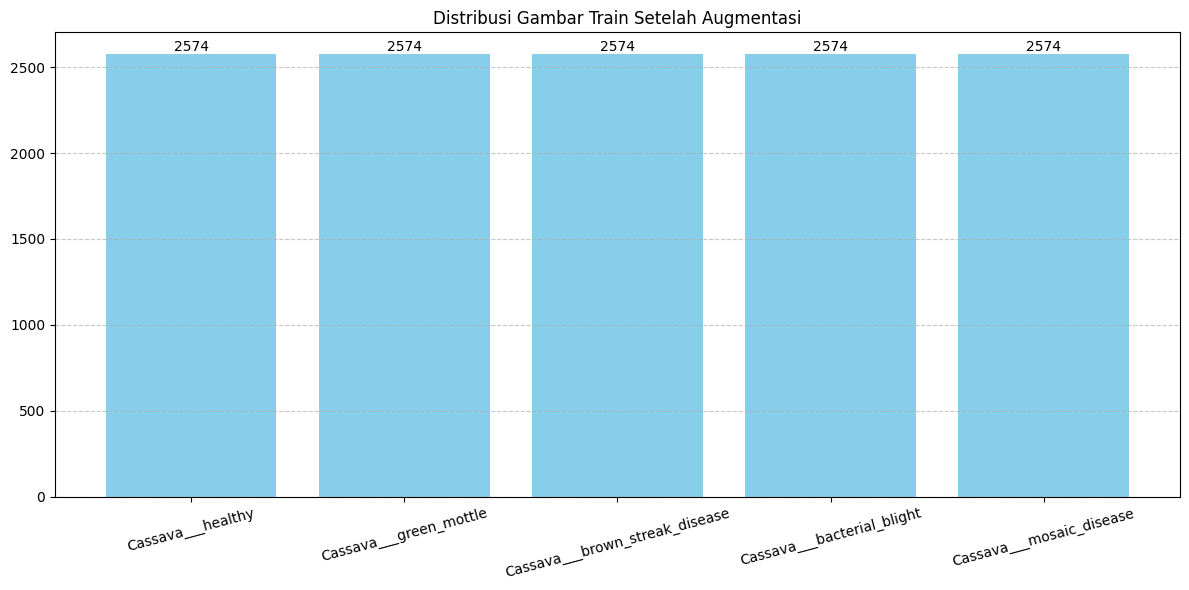

In [13]:
# Hitung jumlah gambar train
train_path = '/kaggle/working/Dataset-Ready/train'
imageCount = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar Train Setelah Augmentasi")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
# Konstanta
BATCH_SIZE = 16
TARGET_SIZE = 299
WORK_DIR = "/kaggle/working/Dataset-Ready"

# Image augmentation untuk data training
train_datagen = ImageDataGenerator(
    preprocessing_function=None,
    zoom_range=0.2,
    cval=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=5,
    fill_mode='constant',
    shear_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2
)

# Hanya rescale untuk validasi
val_datagen = ImageDataGenerator()

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(WORK_DIR, "train"),
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'  # gunakan 'sparse' untuk label numerik
)

# Generator untuk validasi
validation_generator = val_datagen.flow_from_directory(
    directory=os.path.join(WORK_DIR, "val"),
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

# # Generator untuk test
test_generator = ImageDataGenerator() \
    .flow_from_directory(
        os.path.join(WORK_DIR, "test"),  # ganti sesuai path
        target_size=(TARGET_SIZE, TARGET_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

# Langkah per epoch
STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator.samples // BATCH_SIZE


Found 12870 images belonging to 5 classes.
Found 1070 images belonging to 5 classes.
Found 1077 images belonging to 5 classes.


# Modelling

In [15]:
from tensorflow.keras import models, layers

In [16]:
def create_model():
    base_model = EfficientNetB4(include_top=False, weights='imagenet',
                                input_shape=(TARGET_SIZE, TARGET_SIZE, 3))

    model = models.Sequential()

    # Tambahkan base model
    model.add(base_model)

    # Tambahkan layer tambahan setelah EfficientNet
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))

    # Global Average Pooling + Dense
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation='softmax'))  # 5 kelas

    # Kompilasi
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

model = create_model()

I0000 00:00:1748802108.110716      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 10, 10, 1792)        │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 10, 10, 64)          │       1,032,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,781,348 (71.65 MB)

 Trainable params: 18,655,757 (71.17 MB)

 Non-trainable params: 125,591 (490.59 KB)

In [18]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100
)

Epoch 1/100


I0000 00:00:1748802221.796267      88 service.cc:148] XLA service 0x7aa4fc005e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748802221.797371      88 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748802231.766305      88 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748802246.636011      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748802246.822681      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748802247.171709      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748802247.3583

417/805 ━━━━━━━━━━━━━━━━━━━━ 1:52 290ms/step - accuracy: 0.4320 - loss: 1.4481

E0000 00:00:1748802426.835872      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748802427.020481      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748802427.361688      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748802427.561147      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748802428.069226      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

805/805 ━━━━━━━━━━━━━━━━━━━━ 489s 398ms/step - accuracy: 0.4787 - loss: 1.3338 - val_accuracy: 0.5159 - val_loss: 2.1363
Epoch 2/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 244s 303ms/step - accuracy: 0.6470 - loss: 0.9452 - val_accuracy: 0.7131 - val_loss: 0.8336
Epoch 3/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 237s 294ms/step - accuracy: 0.6718 - loss: 0.8706 - val_accuracy: 0.7402 - val_loss: 0.7031
Epoch 4/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 238s 296ms/step - accuracy: 0.6921 - loss: 0.8279 - val_accuracy: 0.3907 - val_loss: 3.3356
Epoch 5/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 240s 298ms/step - accuracy: 0.6950 - loss: 0.8199 - val_accuracy: 0.7486 - val_loss: 0.6651
Epoch 6/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 239s 296ms/step - accuracy: 0.7174 - loss: 0.7785 - val_accuracy: 0.7243 - val_loss: 0.7784
Epoch 7/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 250s 311ms/step - accuracy: 0.7317 - loss: 0.7299 - val_accuracy: 0.7290 - val_loss: 0.7674
Epoch 8/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 261s 324ms/step - accuracy: 0.7369 - los

# Evaluate Model

In [19]:
# Evaluasi pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.6233 - loss: 1.9084

Test Accuracy: 0.7279
Test Loss: 1.3748


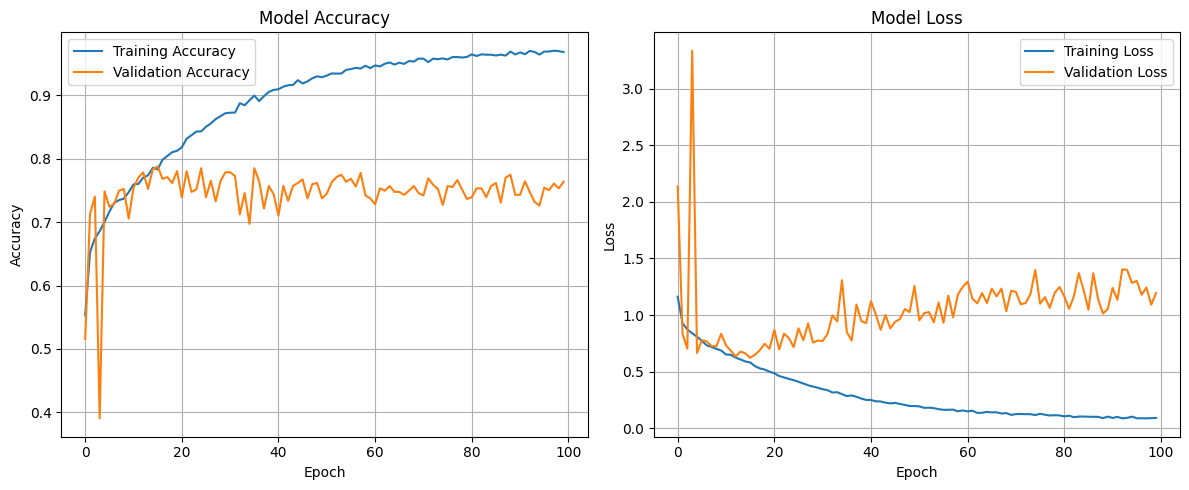

In [20]:
# Fungsi untuk menggambar grafik performa
def plot_model_performance(history):
    # Akurasi
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
plot_model_performance(history)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prediksi pada test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Ambil kelas prediksi

# Label asli
y_true = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())

# Laporan klasifikasi
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step
Classification Report:

                                precision    recall  f1-score   support

    Cassava___bacterial_blight       0.51      0.45      0.48       110
Cassava___brown_streak_disease       0.81      0.68      0.74       212
        Cassava___green_mottle       0.80      0.67      0.73       239
             Cassava___healthy       0.62      0.79      0.69       258
      Cassava___mosaic_disease       0.84      0.87      0.86       258

                      accuracy                           0.73      1077
                     macro avg       0.71      0.69      0.70      1077
                  weighted avg       0.74      0.73      0.73      1077



<Figure size 800x600 with 0 Axes>

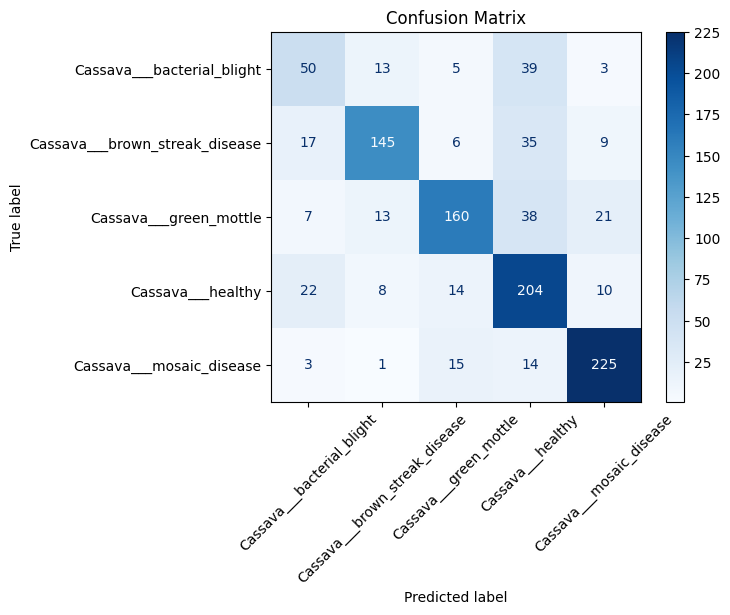

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Tampilkan
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Save and Convert Model

In [23]:
import pickle as pkl

In [24]:
# Mempersiapkan folder untuk menampung model
os.makedirs("saved_model", exist_ok=True)
# os.makedirs("tfjs_model", exist_ok=True)
os.makedirs("pkl_model", exist_ok=True)

In [25]:
# Menyimpan model dalam format SavedModel
model.export('/kaggle/working/saved_model/')

Saved artifact at '/kaggle/working/saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_475')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134850633461840: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134850633462416: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134851198464464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134851198465616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134851198465232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134851198462736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134851198464272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134851198466192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134851039412496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134851039413264: TensorSpec(shape=(), dtype=tf.res

In [26]:
# saved_model_loc = '/kaggle/working/saved_model'

# # Konversi ke format TensorFlow.js dari SavedModel
# !tensorflowjs_converter --input_format=tf_saved_model \
#     --output_format=tfjs_graph_model \
#     {saved_model_loc} /kaggle/working/tfjs_model

In [27]:
# Menyimpan model dalam format pkl
save_dir = '/kaggle/working/pkl_model'
model.save(os.path.join(save_dir, 'model_cassava.h5'))
with open(os.path.join(save_dir, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)